In [71]:
# reconstruct the stdev table (as a function of cloud amount)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def inquire_nongauss_table(table_name, input_cld, input_innov):

    # first read table in:
    read_cloud_bin_next = False
    read_bias_next      = False
    read_stdev_next     = False
    ct = 0
    with open(table_name, 'r') as file:
        # Read the file line by line into a list
        lines = file.readlines()
    
        # Process each line
        for line in lines:
            # basic parameters
            if line[0:9] == 'max_range':
                max_range = float(line[17:])
            elif line[0:2] == 'dx':
                dx        = float(line[17:])
            elif line[0:9] == 'bdy_slope':
                bdy_slope = float(line[17:])
            elif line[0:13] == 'num_cloud_cat':
                num_cloud_cat = float(line[17:])
                stdev = np.zeros((int(num_cloud_cat), 2*int(max_range/dx)+1))
        
            # cloud bin
            if line[0:11] == 'cloud_bin::':
                read_cloud_bin_next = True
                continue
            
            if read_cloud_bin_next:
                cloud_bin = np.array(line.split(), dtype=np.float64)
                read_cloud_bin_next = False
        
            if line[0:6] == 'bias::':
                read_bias_next = True
                continue
            
            if read_bias_next:
                bias = np.array(line.split(), dtype=np.float64)
                read_bias_next = False
            
            if line[0:7] == 'stdev::':
                read_stdev_next = True
                continue
            
            if read_stdev_next:
                stdev[ct,:] = np.array(line.split(), dtype=np.float64)
                ct+=1
                if ct>=num_cloud_cat:
                    read_stdev_next = False
                    
    
    # then interpolate the table to get the standard deviation:
    cc = int(min(num_cloud_cat-1, np.where(input_cld - cloud_bin >= 0)[0][-1]))

    # move the innovation to 'mode relative innovation':
    input_innov = input_innov + bias[cc]
    
    # interpolate to get the stdev:
    if input_innov <= -max_range:
        output_stdev = stdev[cc,0] + bdy_slope*(-max_range - input_innov)
    elif input_innov >= max_range:
        output_stdev = stdev[cc,-1] + bdy_slope*(input_innov - max_range)
    else:
        output_stdev = np.interp(input_innov, np.arange(-max_range, max_range+dx, dx), stdev[cc,:] )

    return output_stdev

In [193]:
sensor  = 'atms'
channel = 'ch18'
predictor = 'sym_cld'

if predictor in ('obs_cld','sym_cld'):
    if sensor == 'amsua':
        if channel in ('ch1','ch2','ch3','ch4'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 1.00 ])
        elif channel in ('ch5'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 0.40, 1.00])
        elif channel in ('ch15'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 1.00])
    elif sensor == 'atms':
        if channel in ('ch1','ch2','ch3','ch4','ch5','ch16'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 1.00 ]) 
        elif channel in ('ch6','ch18'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 0.40, \
                                   0.45, 1.00])
        elif channel in ('ch17'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, 1.00])
        elif channel in ('ch19','ch20','ch21','ch22'):
            cloud_edge = np.array([0.00, 0.03, \
                                   0.06, 0.10, \
                                   0.15, 0.20, \
                                   0.25, 0.30, \
                                   0.35, 0.40, \
                                   0.55, 1.00])
            
elif predictor == 'no_predictor':
    cloud_edge = np.array([0.00, 1.00])

cloud_cat = 0.5*(cloud_edge[:-1] + cloud_edge[1:])


if predictor in ('sym_cld', 'obs_cld'):
    if sensor == 'amsua':
        if channel in ('ch1','ch2','ch15'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1        
        elif channel in ('ch4'):
            bdy_regrid = 15 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 5
            dx_regrid  = 0.01

    if sensor == 'atms':
        if channel in ('ch1','ch2','ch16'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1
        elif channel in ('ch4','ch17','ch18','ch19','ch20','ch21','ch22'):
            bdy_regrid = 20 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 8
            dx_regrid  = 0.01
        elif channel in ('ch6'):
            bdy_regrid = 5
            dx_regrid  = 0.01
            
elif predictor in ('no_predictor'):
    if sensor == 'amsua':
        if channel in ('ch1','ch2','ch15'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1        
        elif channel in ('ch4'):
            bdy_regrid = 15 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 5
            dx_regrid  = 0.01    
    if sensor == 'atms':
        if channel in ('ch1','ch2','ch16'):
            bdy_regrid = 60
            dx_regrid  = 0.1
        elif channel in ('ch3'):
            bdy_regrid = 40
            dx_regrid  = 0.1
        elif channel in ('ch4','ch17','ch18','ch19','ch20','ch21','ch22'):
            bdy_regrid = 20 
            dx_regrid  = 0.05
        elif channel in ('ch5'):
            bdy_regrid = 8
            dx_regrid  = 0.01
        elif channel in ('ch6'):
            bdy_regrid = 5
            dx_regrid  = 0.01

innov_range = np.arange(-bdy_regrid, bdy_regrid + dx_regrid, dx_regrid)

In [194]:
# evaluate the non-Gaussian table:

table_err_ng = np.zeros((len(cloud_cat), len(innov_range)))

for i in range(len(cloud_cat)):
    for j in range(len(innov_range)):
        table_err_ng[i,j] = inquire_nongauss_table(f'/home/Chih-Chi.Hu/python_codes/tables/non_Gaussian_{sensor}_{channel}_OmF_sym_cld_qc_00_03.txt', cloud_cat[i], innov_range[j])


In [195]:
# create the pandas dataframe for AMSUA and ATMS Gaussian tables:

data = {'sensor': ['amsua','amsua','amsua','amsua','amsua','amsua', \
                   'atms','atms','atms','atms','atms',      \
                   'atms','atms','atms','atms','atms',      \
                   'atms','atms','atms'],
       'channel': ['ch1','ch2','ch3','ch4','ch5','ch15', \
                   'ch1','ch2','ch3','ch4','ch5','ch6','ch16','ch17','ch18','ch19','ch20','ch21','ch22'],
       'clear'  : [0.03, 0.03, 0.03, 0.03, 0.00, 0.03, \
                   0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       'cloud'  : [0.35, 0.35, 0.35, 0.35, 0.40, 0.25, \
                   0.35, 0.35, 0.35, 0.35, 0.35, 0.45, 0.35, 0.30, 0.45, 0.55, 0.55, 0.55, 0.55],
       'stdclr' : [2.30, 1.90, 1.50, 0.34, 0.19, 3.40, \
                   2.10, 1.50, 1.30, 0.80, 0.29, 0.14, 2.90, 1.50, 1.14, 1.17, 1.25, 1.37, 1.50],
       'stdcld' : [ 7.50, 12.00, 7.30, 1.22, 0.38, 9.50, \
                    8.60, 15.80, 8.30, 4.40, 1.40, 0.62, 11.00, 5.30, 2.42, 3.10, 3.53, 3.98, 4.05]}
gt = pd.DataFrame(data)

In [196]:
# evaluate the Gaussian table:

# extract the info from sensor/channel
gaussian_info = gt[ (gt['sensor']==sensor) & (gt['channel']==channel) ]

# extract the values in the row:
#print(gaussian_info['clear'].values[0])
clr    = gaussian_info['clear'].values[0]
cld    = gaussian_info['cloud'].values[0]
stdclr = gaussian_info['stdclr'].values[0]
stdcld = gaussian_info['stdcld'].values[0]

table_err_g = np.zeros(len(cloud_cat))
for i in range(len(cloud_cat)):
    if cloud_cat[i] <= clr:
        table_err_g[i] = stdclr
    elif cloud_cat[i] >= cld:
        table_err_g[i] = stdcld
    else:
        dcloud = cloud_cat[i] - clr
        table_err_g[i] = stdclr + (stdcld-stdclr)/(cld-clr)*dcloud

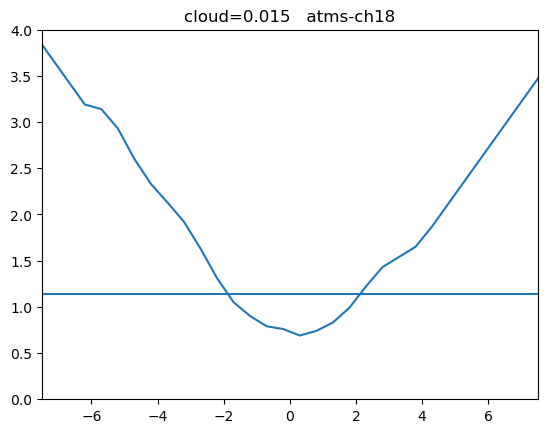

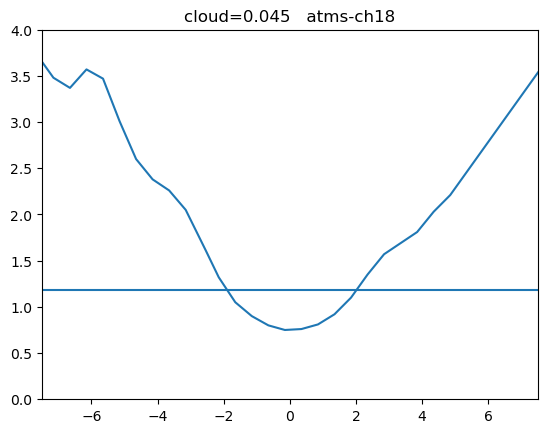

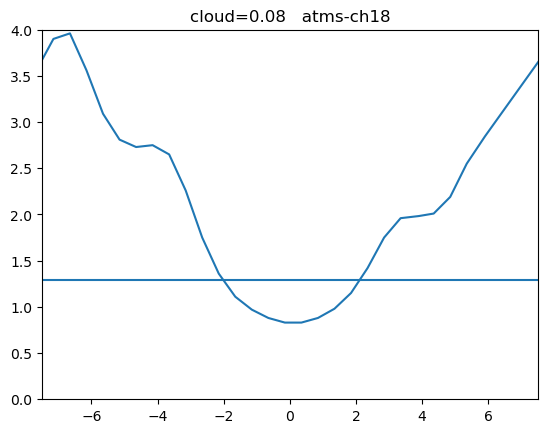

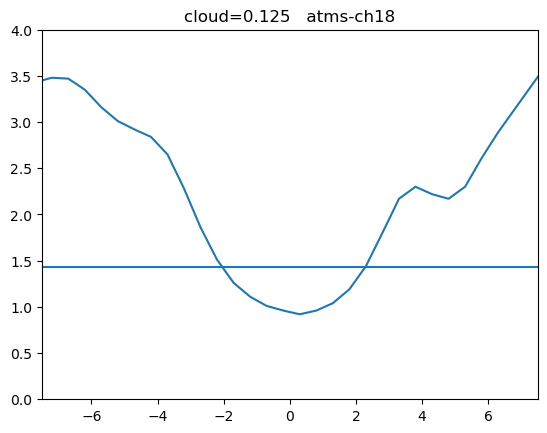

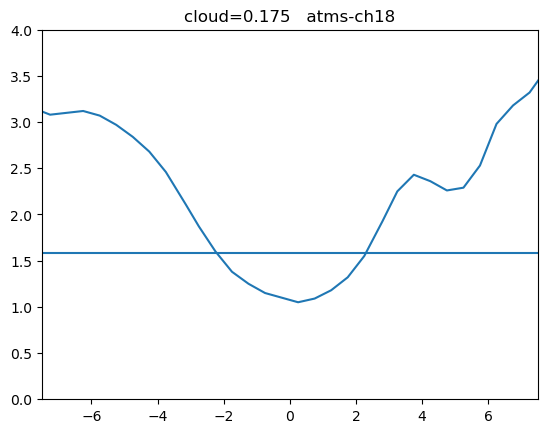

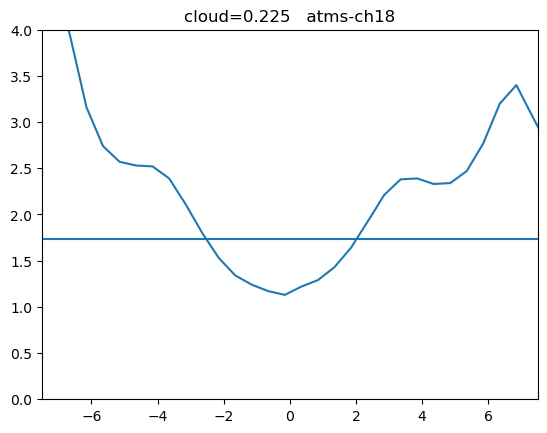

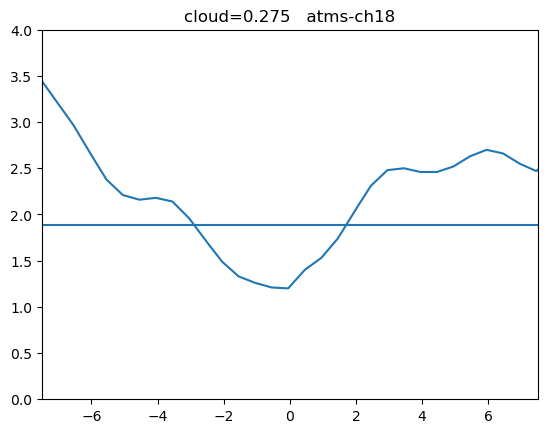

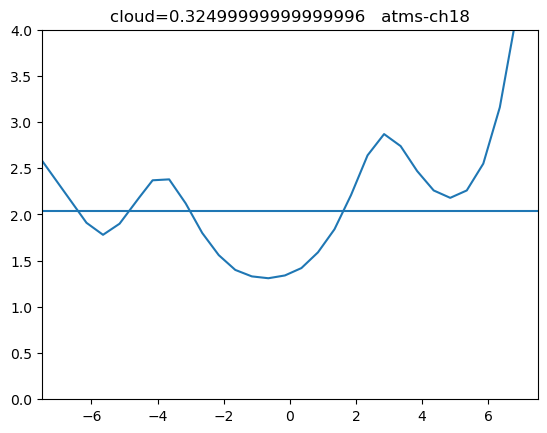

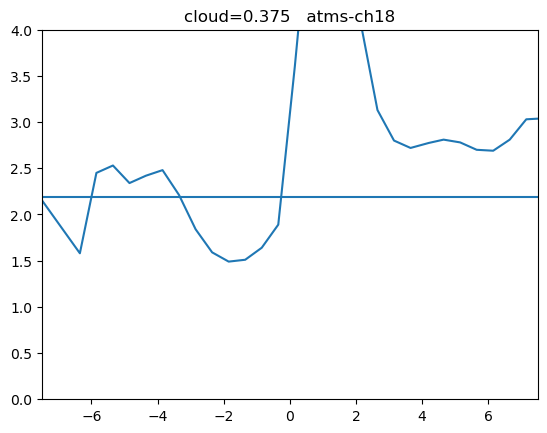

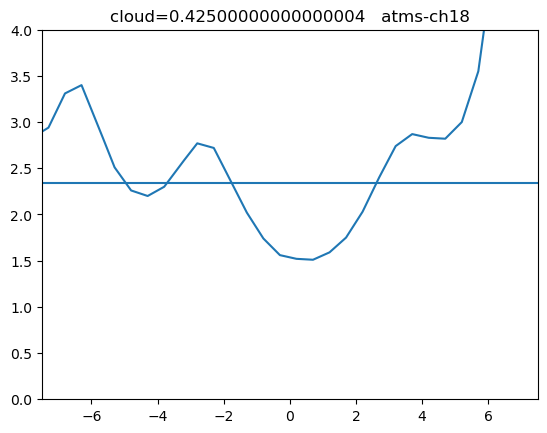

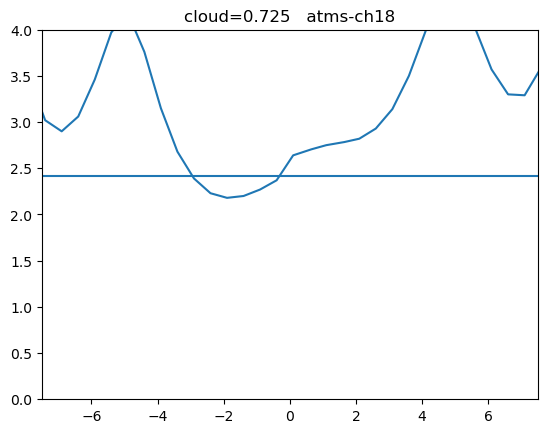

In [206]:
# optional -- still under development

for i in range(len(cloud_cat)):
    plt.plot(innov_range, np.transpose(table_err_ng[i,:]))
    plt.axhline(table_err_g[i])
    plt.title(f'cloud={cloud_cat[i]}   {sensor}-{channel}')
    plt.xlim(-7.5,7.5)
    plt.ylim(0,4)
    plt.show()

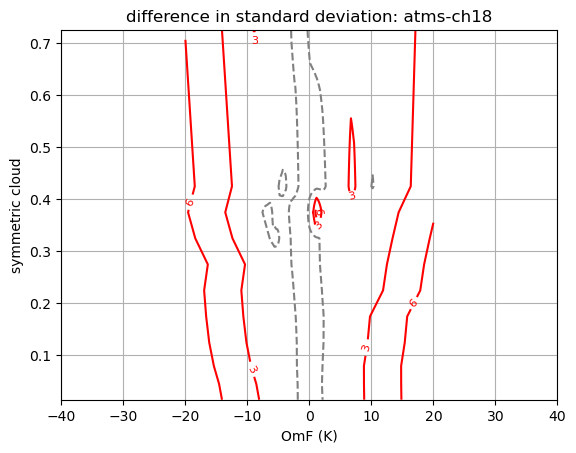

In [197]:
# plot the difference of stdev between Gaussian and non-Gaussian table:
diff_table_err = table_err_ng - np.transpose(np.tile(table_err_g,[len(innov_range),1]))

xx, yy = np.meshgrid(innov_range, cloud_cat)

pp=12
dp= 3
nn=-6
dn=1

contour=plt.contour(xx, yy, diff_table_err, levels=np.arange(dp,pp+dp,dp), colors='red')
plt.clabel(contour, inline=True, fontsize=8)

contour=plt.contour(xx, yy, diff_table_err, levels=[0], linestyles='--', colors=[(0.5, 0.5, 0.5)])

contour1=plt.contour(xx, yy, diff_table_err, levels=np.arange(-6,0,dn), colors='blue')
plt.clabel(contour1, inline=True, fontsize=8)

plt.xlim(-40,40)
plt.ylim(cloud_cat[0],cloud_cat[-1])
plt.xlabel('OmF (K)')
plt.ylabel('symmetric cloud')
plt.grid(True)
plt.title(f'difference in standard deviation: {sensor}-{channel}')
plt.show()


#vv= 15
#dv=  3
#levels = np.arange(-vv,vv+dv,dv)
#contour=plt.contour(xx, yy, diff_table_err, cmap='coolwarm', levels=levels)
#plt.colorbar(contour, label='Value', ticks=np.arange(-vv,vv+5*dv, 5*dv))
#plt.xlim(-40,40)
#plt.ylim(cloud_cat[0],cloud_cat[-1])
#plt.grid(True)
#plt.show()

In [109]:
print(innov_range)

[-60.  -59.9 -59.8 ...  59.8  59.9  60. ]
